In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import abc
import einx
import torch
import torch.nn as nn
import torch.distributions as D
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Tuple
from torch import Tensor
from torch.nn import Module
from einops import rearrange, repeat

In [4]:
import flow

In [5]:
sns.set_theme()

(np.float64(-2.196175479888916),
 np.float64(2.1995591163635253),
 np.float64(-2.1933215260505676),
 np.float64(2.1944122910499573))

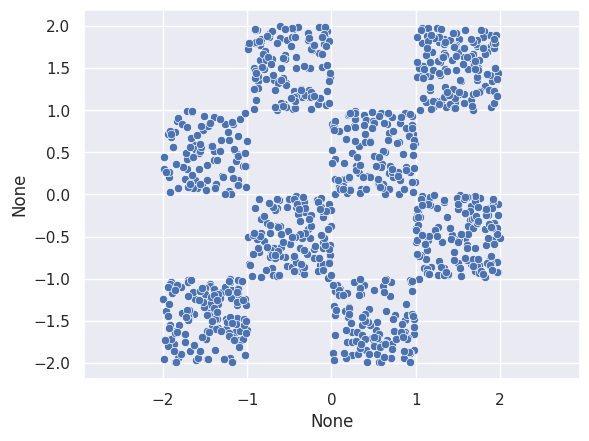

In [285]:
class Sampleable(abc.ABC):
    @abc.abstractmethod
    def sample(self, samples: torch.Size | Tuple) -> Tensor:
        raise NotImplementedError()


class Circles(Module, Sampleable):
    _dummy: Tensor

    def __init__(
        self,
        *args,
        n_modes: int,
        mean: Tensor | None = None,
        scale: Tensor | None = None,
        offset_degree: float = 0.0,
        radius: float = torch.pi,
        **kwargs,
    ) -> None:
        super().__init__(*args, **kwargs)

        # Default init
        mean = torch.zeros((2,)) if mean is None else mean
        scale = torch.ones((2,)) if scale is None else scale

        # Validate args
        assert mean.size() == (2,)
        assert scale.size() == (2,)

        # Split a circle in n_modes then obtain (x, y) for those points
        theta = 2 * torch.pi * torch.arange(n_modes) / n_modes
        mean_x = radius * torch.cos(theta)
        mean_y = radius * torch.sin(theta)
        means = rearrange([mean_x, mean_y], "b n -> b n")

        # Obtain rotation matrix from offset_degrees
        rot_degree = torch.tensor(offset_degree)
        rot = torch.deg2rad(rot_degree)
        rot_mat = torch.tensor(
            [[torch.cos(rot), -torch.sin(rot)], [torch.sin(rot), torch.cos(rot)]]
        )

        # Rotate the points on circle
        means = rot_mat @ means
        means = (mean + means.T).T

        # Reshape data to (n_modes, 2D)
        means = rearrange(means, "d n -> n d")
        scale = repeat(scale, "d -> n d", n=n_modes)

        # Compose distribution
        com = D.Independent(D.Normal(means, scale), 1)
        mix = D.Categorical(torch.ones(n_modes))
        self._dist = D.MixtureSameFamily(mix, com)
        self.register_buffer("_dummy", torch.empty((0,)))

    def sample(self, samples: torch.Size | Tuple) -> Tensor:
        return self._dist.sample(samples).to(self._dummy.device)


class Checkers(Module, Sampleable):
    _dummy: Tensor

    def __init__(self, *args, n_patches: int, patch_size: float, patch_fill: bool = True, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        # Validate args
        assert n_patches >= 0, 'number of patches must be positive'
        assert patch_size > 0, 'a patch size must be strictly positive'

        # Save parameters
        self.p_size_ = patch_size
        self.n_patches_ = n_patches
        self.t_patches_ = (n_patches * 2)**2 // 2
        self.fill_toggle_ = 0 if patch_fill else 1

        # Total number of patches per row
        self.patch_dist = D.Categorical(torch.ones(self.t_patches_))
        self.point_dist = D.Uniform(low=torch.zeros(2), high=torch.full((2,), patch_size))


    def sample(self, samples: torch.Size):
        # Sample independent class and points
        cls = self.patch_dist.sample(samples)
        pts = self.point_dist.sample(samples)

        # Determine offsets
        y_offset =  cls // self.n_patches_
        x_offset = (cls  % self.n_patches_) * 2 + ((y_offset + self.fill_toggle_) % 2 != 0).float()

        # Translate all points according to class
        pts[:, 0] = pts[:, 0] + x_offset * self.p_size_
        pts[:, 1] = pts[:, 1] - y_offset * self.p_size_

        # Translate all points relative to center
        pts[:, 0] = pts[:, 0] - ( self.n_patches_      * self.p_size_)
        pts[:, 1] = pts[:, 1] + ((self.n_patches_ - 1) * self.p_size_)

        return pts

checkerboard  = Checkers(n_patches=2, patch_size=1, patch_fill=False)

samples = checkerboard.sample((1000,))
samples = rearrange(samples, 'n d -> d n')
x = samples[0, :]
y = samples[1, :]
sns.scatterplot(x=x, y=y)
plt.axis('equal')


<Axes: xlabel='None', ylabel='None'>

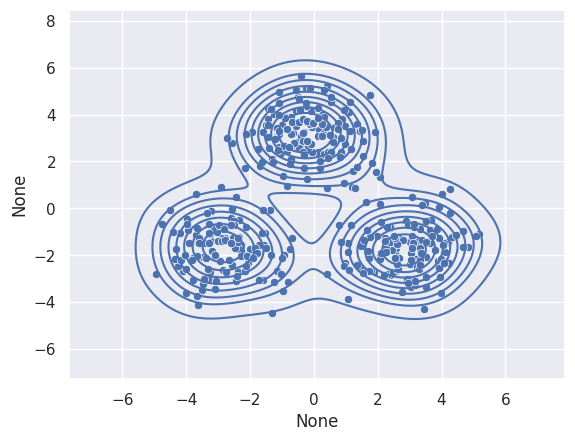

In [ ]:
circles = Circles(n_modes=3, offset_degree=90)

samples = circles.sample((400,))
samples = rearrange(samples, 'n d -> d n')
x = samples[0, :]
y = samples[1, :]
sns.scatterplot(x=x, y=y)
sns.kdeplot(x=x, y=y)